# Stock Price Predictor

## Setup and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# we will need it for standardization
from sklearn.preprocessing import MinMaxScaler

# we will need them for the RNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


## Import data
Only the training set

In [2]:
# reads the csv file and make a pandas data frame
datasetTrain = pd.read_csv("Google_Stock_Price_Train.csv")

In [3]:
# takes only the desired col, col #1, we use 1:2 to make it a numpy array
# if we miss the .values, it will remain a pandas object
trainingSet = datasetTrain.iloc[:, 1:2].values

## Data preparation
### Feature Scaling
We are going to use normalization, when we have a Sigmoid. it is better to use normalization

In [4]:
scale = MinMaxScaler(feature_range= (0,1))
# it will get the min and min of value and applies the formula to standardize
scaledTrainingSet = scale.fit_transform(trainingSet)

## Designing the RNN

### Creating data structure with time step
We should select the timestep, a timestep of 60 is the number of steps that the model is going to look back too in order to predict the next one. In this case, it is going to be 60 working days!

In [54]:
%%time
timeStep = 120

XTrain = []
YTrain = []

for i in range(timeStep, scaledTrainingSet.shape[0]):
    # it will assemble the data from the past 60 days in an array
    # and save them in a large data set called XTrain
    # don't forget to add the colomn index: 0
    # then we want guess the price in the ith index, we save it in 
    # YTrain
    XTrain.append(scaledTrainingSet[i-timeStep:i, 0])
    YTrain.append([scaledTrainingSet[i,0]])

# Don't forget to convert them to np arrays
XTrain = np.array(XTrain)
YTrain = np.array(YTrain)

Wall time: 3.01 ms


### Reshaping
We need to change the data shape to match our RNN inputs: <br>
XTrain.shape: (a,b,c) <br>
a= number of observation or batch size, in this case number of prices that we have <br>
b= time step <br>
c= input dimension, if we have more than one data entry (price of stock, news, ...) <br>

In [55]:
XTrain = np.reshape(XTrain, (XTrain.shape[0],XTrain.shape[1],1))
print(XTrain.shape)

(1138, 120, 1)


### Initialize RNN

Variables in LSTM layer <br>
Units: number of neuron in the LSTM layer, we put it 50 for this complex task <br><br>
Return sequence: true means we are making stacked model. For the last one we don't do that, because there is no next layer to send data for. <br><br>
Shape: the same shape as the XTrain, but not the first one. The first one will be detected automatically.

In [74]:
%%time
regressor =Sequential()
dropoutRate = 0.2

# add the LSTM and the dropout regularization
regressor.add(LSTM(100,return_sequences= True,input_shape = (XTrain.shape[1],1)))
regressor.add(Dropout(rate = dropoutRate))

# add 2nd LSTM and the dropout regularization
regressor.add(LSTM(100,return_sequences= True))
regressor.add(Dropout(rate = dropoutRate))


# add 3rd LSTM and the dropout regularization
regressor.add(LSTM(100,return_sequences= True))
regressor.add(Dropout(rate = dropoutRate))

# add 4th LSTM and the dropout regularization
regressor.add(LSTM(100))
regressor.add(Dropout(rate = dropoutRate))

# add the output layer
regressor.add(Dense(units = 1))

Wall time: 943 ms


### Compile the RNN
adam is the best optimizer for RNN

In [75]:
regressor.compile(optimizer = 'adam', loss= 'mean_squared_error')

In [77]:
%%time
regressor.fit(XTrain, YTrain, 
              epochs = 25,
              batch_size = 64)

Epoch 1/25
1138/1138 [==============================] - 18s 15ms/step - loss: 0.0027
Epoch 2/25
1138/1138 [==============================] - 17s 15ms/step - loss: 0.0029
Epoch 3/25
1138/1138 [==============================] - 18s 16ms/step - loss: 0.0037
Epoch 4/25
1138/1138 [==============================] - 18s 16ms/step - loss: 0.0035
Epoch 5/25
1138/1138 [==============================] - 18s 15ms/step - loss: 0.0031
Epoch 6/25
1138/1138 [==============================] - 18s 15ms/step - loss: 0.0027
Epoch 7/25
1138/1138 [==============================] - 18s 15ms/step - loss: 0.0026
Epoch 8/25
1138/1138 [==============================] - 18s 15ms/step - loss: 0.0027
Epoch 9/25
1138/1138 [==============================] - 18s 16ms/step - loss: 0.0028
Epoch 10/25
1138/1138 [==============================] - 18s 16ms/step - loss: 0.0029
Epoch 11/25
1138/1138 [==============================] - 17s 15ms/step - loss: 0.0026
Epoch 12/25
1138/1138 [==============================] - 18s 16

### Evaluate

In [78]:
datasetTest = pd.read_csv("Google_Stock_Price_Test.csv")
testSet = datasetTest.iloc[:, 1:2].values
testSet.shape

(20, 1)

We should be really careful about scaling the test set. But we finally want to have unscaled prediction.

In [79]:
# concatenating data
totalDataset = pd.concat((datasetTrain['Open'], datasetTest['Open']),axis = 0)
totalSet = datasetTrain.iloc[:, 1:2].values
print (len(totalSet))

1258


In [80]:
inputs = totalDataset[len(totalSet)-len(testSet)-timeStep:].values
inputs = inputs.reshape(-1,1)
inputs = scale.transform(inputs)
print(inputs.shape)

(160, 1)


In [81]:
XTest = []
for i in range (timeStep,timeStep+len(testSet)):
    XTest.append(inputs[i-timeStep:i,0])
XTest = np.array(XTest)
print(XTest.shape)
XTest = np.reshape(XTest, (XTest.shape[0],XTest.shape[1],1))

(20, 120)


### Predict

In [82]:
%%time
predicted = regressor.predict(XTest)
rescaledPredicted = scale.inverse_transform(predicted)
print(rescaledPredicted)

[[ 775.61010742]
 [ 775.4765625 ]
 [ 774.72399902]
 [ 773.69140625]
 [ 772.62677002]
 [ 771.92053223]
 [ 771.95037842]
 [ 772.94958496]
 [ 775.06536865]
 [ 778.25054932]
 [ 782.23199463]
 [ 786.67486572]
 [ 790.99835205]
 [ 794.86810303]
 [ 798.07958984]
 [ 800.48254395]
 [ 802.02093506]
 [ 802.75097656]
 [ 802.87542725]
 [ 802.40454102]]
Wall time: 1.17 s


### Visualization

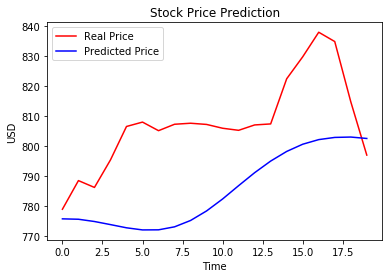

In [83]:
plt.plot(testSet,color = 'red', label= 'Real Price')
plt.plot(rescaledPredicted, color = 'blue', label= 'Predicted Price')
plt.title("Stock Price Prediction")
plt.xlabel('Time')
plt.ylabel('USD')
plt.legend()
plt.show()

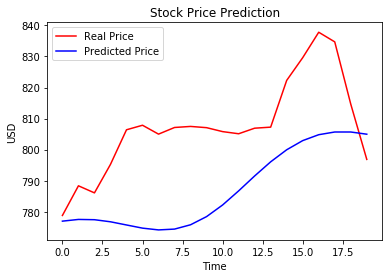

In [72]:
plt.plot(testSet,color = 'red', label= 'Real Price')
plt.plot(rescaledPredicted, color = 'blue', label= 'Predicted Price')
plt.title("Stock Price Prediction")
plt.xlabel('Time')
plt.ylabel('USD')
plt.legend()
plt.show()

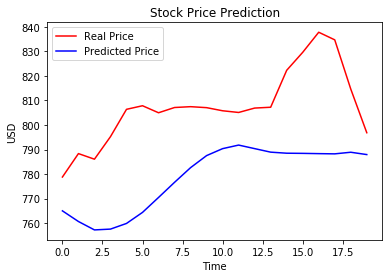

In [46]:
plt.plot(testSet,color = 'red', label= 'Real Price')
plt.plot(rescaledPredicted, color = 'blue', label= 'Predicted Price')
plt.title("Stock Price Prediction")
plt.xlabel('Time')
plt.ylabel('USD')
plt.legend()
plt.show()